# *RECONSTRUCTION VALIDATION*

The Analog Method (AM) is a statistical downscaling method very well suited for reconstruction of climatic time series. The reconstruction can reproduce the climatic characteristics of the local phenomena a certain region, based on the relationship between the large scale and the observed local weather patterns.

To validate the quality of the reconstructions is the important to look how the climatic characteristics are reproduced.

This notebook evaluates the skill of the reconstructions and compares it to the skill of the renalysis looking at the following elements:

- Time series skill (Bias, Heidke Skill Score, SSMSE and Taylor diagrams) for daily, monthly and yearly series
- Seasonality
- Equality of distributions
- Daily indices (Days above zero degree, days of precipitation above threshold, dry spells)

In [31]:
import os
import cfgrib
import datetime
import itertools
import rascal.utils
import rascal.analogs
import rascal.skill_evaluation

import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from scipy.stats import percentileofscore

In [32]:
observations_directory = "./data/observations/"
reanalysis_directory = "/home/alvaro/data/NWP/era20c/"
reconstructions_directory = "./output/PCNR/SURF_71.162andSURF_72.162-SURF_71.162andSURF_72.162-1"

In [33]:
initial_year = 1900
final_year = 2010

station_to_validate = "navacerrada"
variable_to_validate = "PCNR"

groupings = {
    "TMEAN": "mean",
    "TMAX": "mean",
    "TMIN": "mean",
    "PCNR": "hydrosum"
}

reanalysis_variables = {
    "TMEAN": ["SURF_167"],
    "TMAX": ["SURF_167"],
    "TMIN": ["SURF_167"],
    "PCNR": ["SURF_228"]
}

reanalysis_grouping = {
    "TMEAN": "1D_mean",
    "TMAX": "1D_max",
    "TMIN": "1D_min",
    "PCNR": "1D_sum"
}

units = {
    "TMEAN": "[$^\circ$C]",
    "TMAX": "[$^\circ$C]",
    "TMIN": "[$^\circ$C]",
    "PCNR": "[mm]"
}

# 0) LOAD DATA 

### 0.1) STATION DATA

In [34]:
station = rascal.utils.Station(path= observations_directory + station_to_validate + '/')
station_data = station.get_data(variable=variable_to_validate)
station_data.index.name = "time"

### 0.2) REANALYSIS DATA

In [35]:
reanalysis_data_name = "_".join([station.name, variable_to_validate, "ERA20C.csv"])

if os.path.exists(reanalysis_data_name):
    reanalysis_data = pd.read_csv(reanalysis_data_name, index_col=0)
    
else:
        
    # Years of the reanalysis data
    years = [str(y) for y in range(initial_year, final_year + 1)]

    # The precipitation is a forecast variable in ERA20C, select only one ensemble member
    if variable_to_validate == 'PCNR':
        ensemble_member = 0
    else:
        ensemble_member = None

    # Get the file paths of the reanalysis variable
    secondary_predictor_files = rascal.utils.get_files(
        nwp_path=reanalysis_directory,
        variables=reanalysis_variables[variable_to_validate],
        dates=years,
        file_format=".grib"
    )

    # Get the variable as a time series in the gridpoint of the station
    reanalysis = rascal.analogs.Predictor(
        paths=secondary_predictor_files,
        grouping=reanalysis_grouping[variable_to_validate],
        lat_min=station.latitude,
        lat_max=station.latitude,
        lon_min=station.longitude,
        lon_max=station.longitude,
        mosaic=False,
        number=ensemble_member
    )
    reanalysis_data = reanalysis.data.drop_vars(["latitude", "longitude"]).to_dataframe()
                
    # Change variable name to RASCAL common acronym
    reanalysis_data.columns = [variable_to_validate]

    # Change units
    # Kelvin to Celsius
    if variable_to_validate in ["TMAX", "TMIN", "TMEAN", "TMPA"]:
        reanalysis_data = reanalysis_data-273.1
    # m to mm
    elif variable_to_validate == "PCNR":
        reanalysis_data = reanalysis_data*1000
    
    reanalysis_data.to_csv(reanalysis_data_name)


Function 'get_files' executed in 0.0014s
Function 'open_data' executed in 241.5588s


### 0.3) RECONSTRUCTIONS DATA

### 0.3.1) DAILY RECONSTRUCTIONS

Get all the simulations in the directory as a dataframe

In [36]:
reconstructions_daily = rascal.skill_evaluation.get_ensemble(
    filepath=reconstructions_directory,
    station_to_validate=station_to_validate, 
    variable_to_validate=variable_to_validate,
    freq='1D',
    grouping=groupings[variable_to_validate]
)

if groupings[variable_to_validate] == "mean":
    station_data_daily = station_data.resample('1D').mean()
    reanalysis_data_daily = reanalysis_data.resample('1D').mean()
elif groupings[variable_to_validate] == "sum" or groupings[variable_to_validate] == "hydrosum" :
    reanalysis_data_daily = reanalysis_data.resample('1D').sum()
    station_data_daily = station_data.resample('1D').sum()

Get the ensemble as a dictionary where the key is the similarity method. Include the reanalysis original data.

In [37]:
daily_ensemble = rascal.skill_evaluation.ensemble_to_dict(reconstructions_daily)
daily_ensemble["reanalysis"] = reanalysis_data_daily

### 0.3.2) MONTHLY RECONSTRUCTIONS

Get all the simulations in the directory as a dataframe

In [38]:
reconstructions_monthly = rascal.skill_evaluation.get_ensemble(
    filepath=reconstructions_directory,
    station_to_validate=station_to_validate, 
    variable_to_validate=variable_to_validate,
    freq='1m',
    grouping=groupings[variable_to_validate]
)
if groupings[variable_to_validate] == "mean":
    station_data_monthly = station_data.resample('1m').mean()
    reanalysis_data_monthly = reanalysis_data.resample('1m').mean()
elif groupings[variable_to_validate] == "sum" or groupings[variable_to_validate] == "hydrosum" :
    station_data_monthly = station_data.resample('1m').sum()
    reanalysis_data_monthly = reanalysis_data.resample('1m').sum()

Get the ensemble as a dictionary where the key is the similarity method. Include the reanalysis original data.

In [39]:
monthly_ensemble = rascal.skill_evaluation.ensemble_to_dict(reconstructions_monthly)
monthly_ensemble["reanalysis"] = reanalysis_data_monthly

### 0.3.3) YEARLY RECONSTRUCTIONS

Get all the simulations in the directory as a dataframe

In [40]:
reconstructions_yearly = rascal.skill_evaluation.get_ensemble(
    filepath=reconstructions_directory,
    station_to_validate=station_to_validate, 
    variable_to_validate=variable_to_validate,
    freq='1Y',
    grouping=groupings[variable_to_validate]
)
if groupings[variable_to_validate] == "mean":
    
    station_data_yearly = station_data.resample('1Y').mean()
    reanalysis_data_yearly = reanalysis_data.resample('1Y').mean()
    
elif groupings[variable_to_validate] == "sum":
    
    station_data_yearly = station_data.resample('1Y').sum()
    reanalysis_data_yearly = reanalysis_data.resample('1Y').sum()
    
elif groupings[variable_to_validate] == "hydrosum":
    
    station_data_yearly = rascal.skill_evaluation.get_hydrological_years(station_data)
    station_data_yearly = station_data_yearly.groupby("hydroyear").sum()
    station_data_yearly.index.name = "time"
    
    reanalysis_data_yearly = rascal.skill_evaluation.get_hydrological_years(reanalysis_data)
    reanalysis_data_yearly = reanalysis_data_yearly.groupby("hydroyear").sum()
    reanalysis_data_yearly.index.name = "time"
    
    station_data = station_data.drop(columns=["hydroyear"])

Get the ensemble as a dictionary where the key is the similarity method. Include the reanalysis original data.

In [41]:
yearly_ensemble = rascal.skill_evaluation.ensemble_to_dict(reconstructions_yearly)
yearly_ensemble["reanalysis"] = reanalysis_data_yearly

# 1) DAILY SERIES

### 1.1) Daily time series

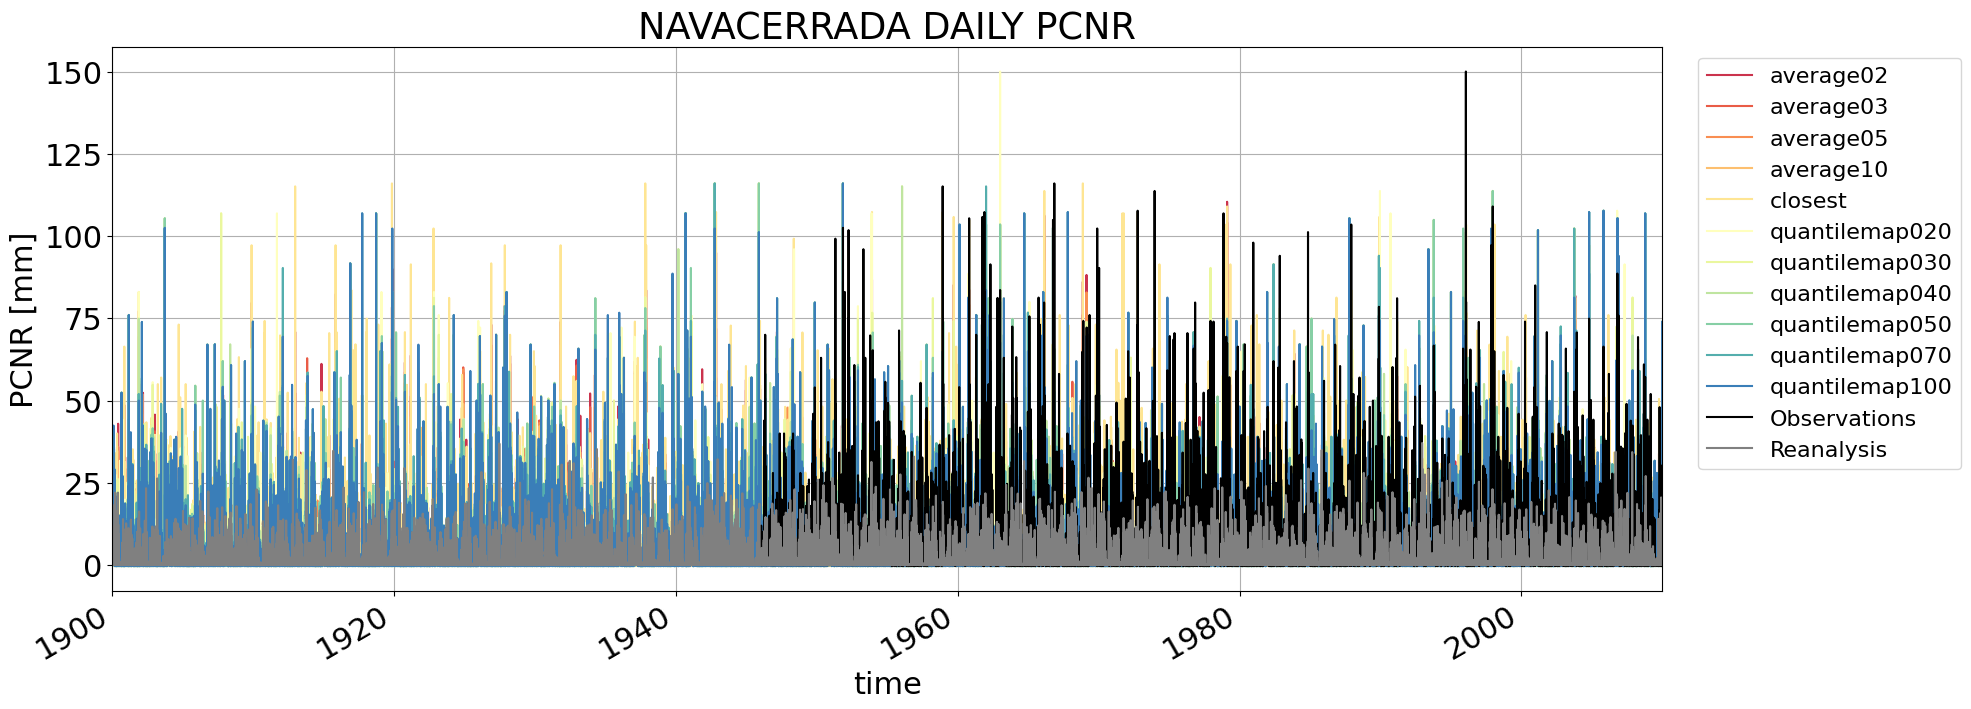

In [42]:
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(20,8))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=reconstructions_daily, 
    x="time", 
    y=variable_to_validate, 
    hue="similarity_method", 
    palette="Spectral"
)
station_data_daily[variable_to_validate].plot(ax=ax, color="black", label="Observations")
reanalysis_data_daily[variable_to_validate].plot(ax=ax, color="grey", label="Reanalysis")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.2, 1], fontsize=16)
ax.set_xlim(years[0], years[-1])
ax.set_title(station.name.upper() + " DAILY " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
ax.grid()
plt.show()

### 1.2) Daily skill table

In [43]:
station_daily_std, daily_skill = rascal.skill_evaluation.get_skill(
    observation=station_data_daily, 
    simulations=daily_ensemble,
    variable=variable_to_validate,
    reference_model=reanalysis_data_daily,
    threshold=1
)

In [44]:
daily_skill

,bias,rmse,r2,std,ssmse,hss,bs
average02,0.080425,9.165793,0.382423,7.252966,0.11116,0.281203,0.283813
average03,0.083914,8.684005,0.417792,6.638374,0.202145,0.2476,0.297081
average05,0.11399,8.267378,0.453895,6.040685,0.276865,0.208769,0.312413
average10,0.131436,7.885135,0.496347,5.434325,0.342188,0.161617,0.331031
closest,0.016731,10.487534,0.317873,8.790849,-0.163671,0.314594,0.270629
quantilemap020,-0.022771,8.877955,0.490395,8.295852,0.166109,0.326435,0.265953
quantilemap030,-0.013205,8.765558,0.504774,8.302019,0.187089,0.333369,0.263216
quantilemap040,-0.021052,8.75465,0.509561,8.367571,0.189111,0.346277,0.258119
quantilemap050,-0.01668,8.777041,0.511472,8.43232,0.184958,0.355558,0.254454
quantilemap070,0.009102,8.793521,0.508823,8.436479,0.181895,0.365692,0.250453


### 1.3) Daily Taylor diagram

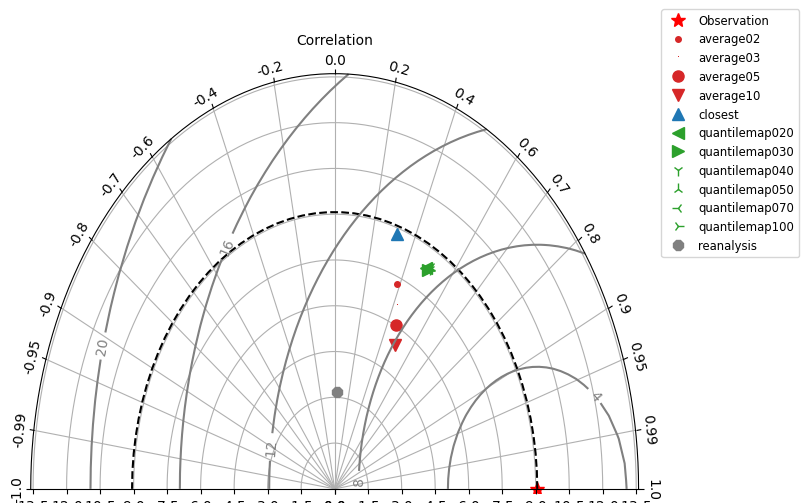

In [45]:
rascal.skill_evaluation.taylor_test(station_daily_std, daily_skill)

# 2) MONTHLY SERIES

### 2.1) Monthly time series

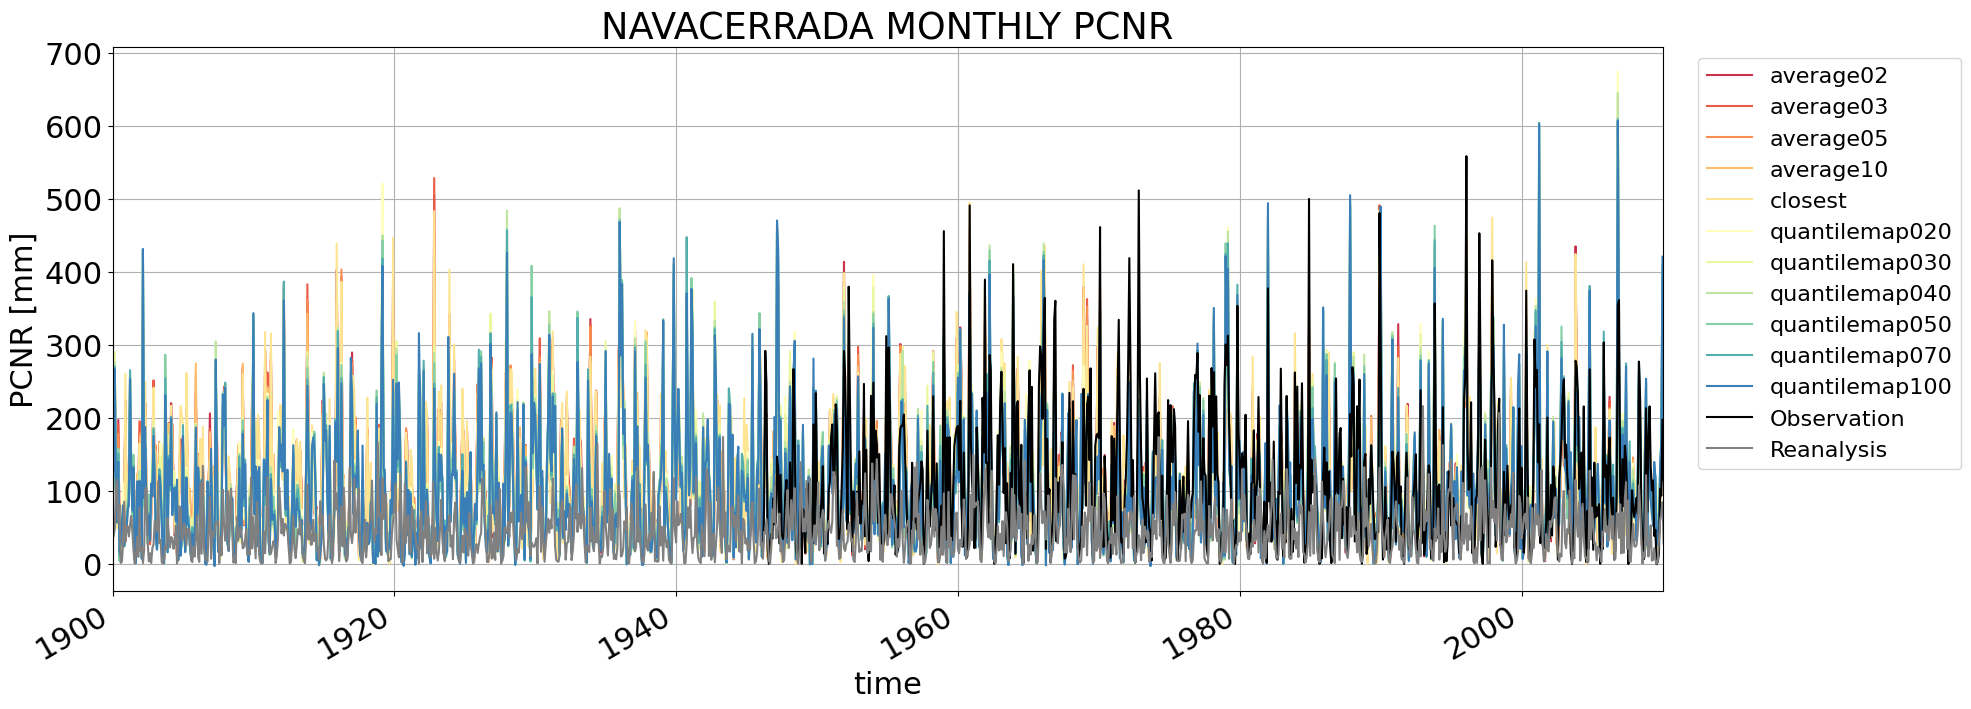

In [46]:
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(20,8))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=reconstructions_monthly, 
    x="time", 
    y=variable_to_validate, 
    hue="similarity_method", 
    palette="Spectral"
)
station_data_monthly[variable_to_validate].plot(ax=ax, color="black", label="Observation")
reanalysis_data_monthly[variable_to_validate].plot(ax=ax, color="grey", label="Reanalysis")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.2, 1], fontsize=16)
ax.set_xlim(years[0], years[-1])
ax.set_title(station.name.upper() + " MONTHLY " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
ax.grid()
plt.show()

### 2.2) Monthly skill table

In [47]:
station_monthly_std, monthly_skill = rascal.skill_evaluation.get_skill(
    observation=station_data_monthly, 
    simulations=monthly_ensemble,
    variable=variable_to_validate
)

In [48]:
monthly_skill

,bias,rmse,r2,std
average02,2.44792,61.484756,0.761973,81.422204
average03,2.554102,59.088167,0.778573,79.760267
average05,3.469546,57.483789,0.789624,77.650283
average10,4.00053,56.244956,0.79849,75.101247
closest,0.509231,66.132938,0.739492,86.942142
quantilemap020,-0.693077,69.355982,0.710276,86.070045
quantilemap030,-0.401923,68.769015,0.716594,87.014817
quantilemap040,-0.640769,70.30311,0.709407,89.17547
quantilemap050,-0.507692,70.01301,0.71484,90.170934
quantilemap070,0.277051,70.599471,0.710883,90.37434


### 2.3) Monthly Taylor diagram

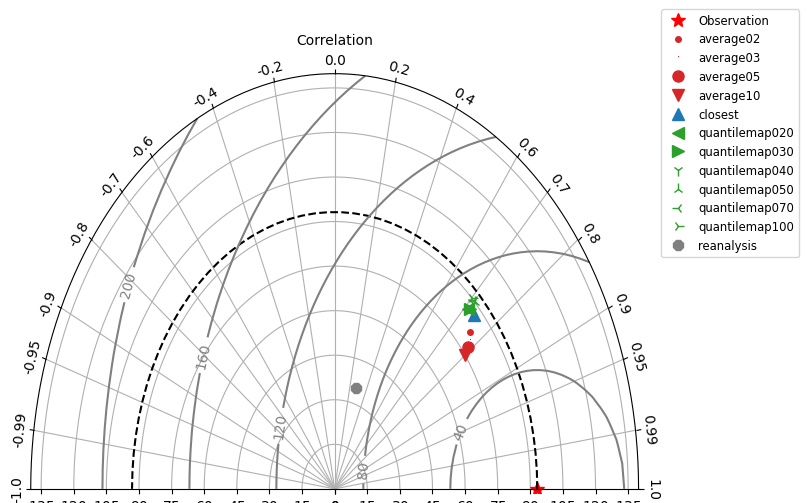

In [49]:
rascal.skill_evaluation.taylor_test(station_monthly_std, monthly_skill)

# 3) YEARLY SERIES

### 3.1) Yearly time series

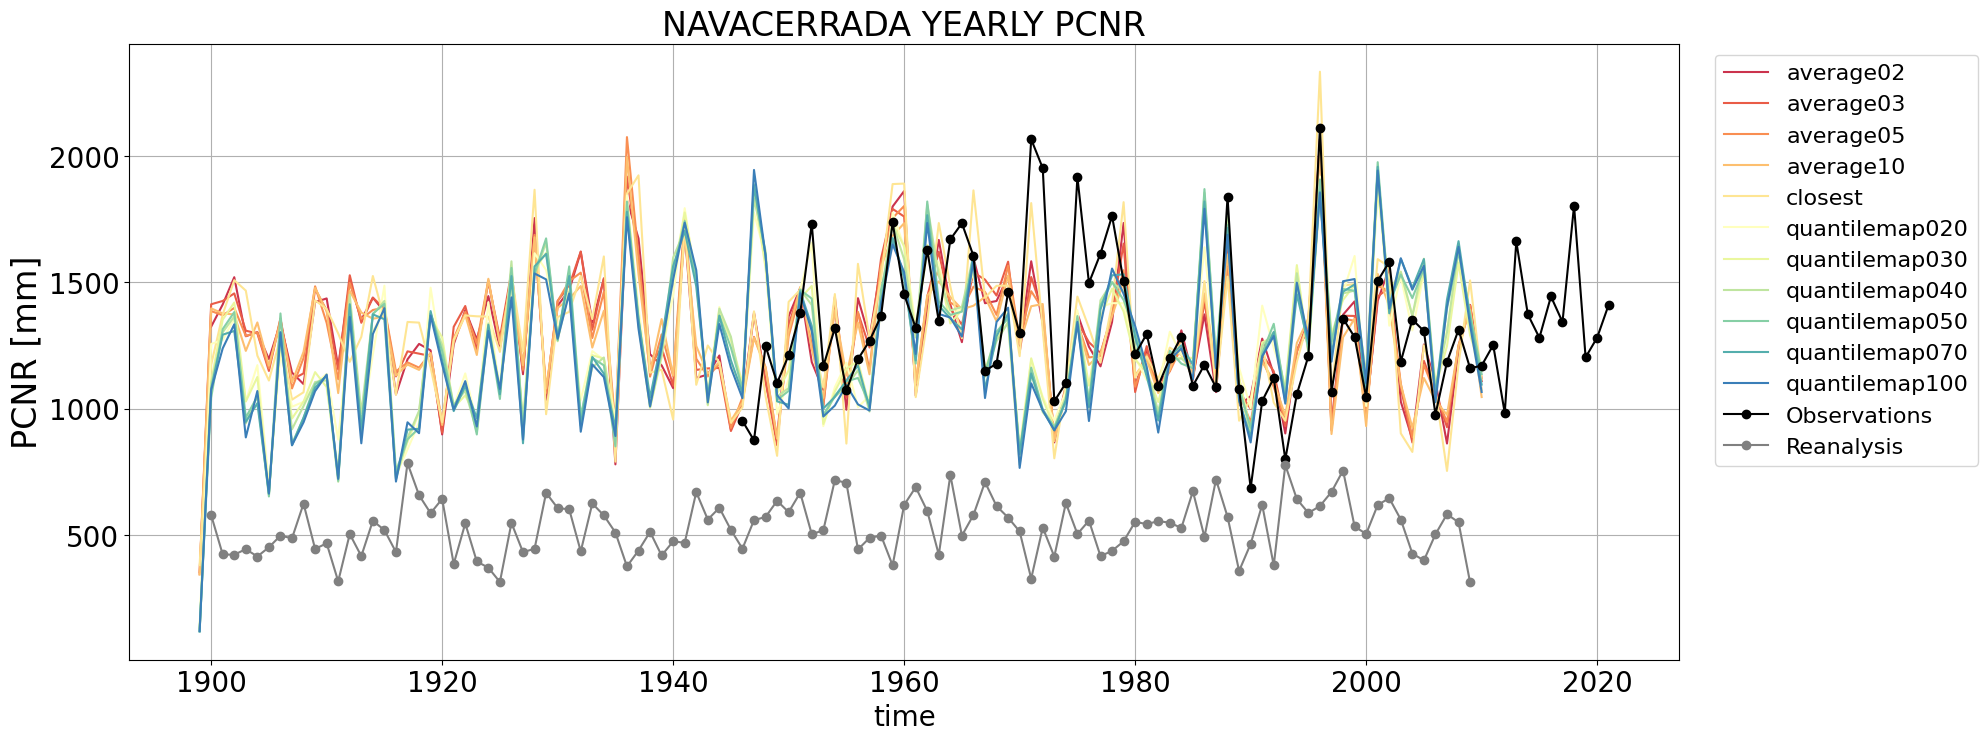

In [50]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,8))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=reconstructions_yearly[1:], 
    x="time", 
    y=variable_to_validate, 
    hue="similarity_method", 
    palette="Spectral"
)
station_data_yearly[variable_to_validate][1:-1].plot(ax=ax, color="black", label="Observations", marker="o")
reanalysis_data_yearly[variable_to_validate][1:-1].plot(ax=ax, color="grey", label="Reanalysis", marker="o")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.2, 1], fontsize=16)

ax.set_ylabel(variable_to_validate, fontsize=24)
# ax.set_xlim(years[0], years[-1])
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
ax.set_title(station.name.upper() + " YEARLY " + variable_to_validate)
ax.grid()

plt.show()

### 3.2) Yearly skill table

In [51]:
station_yearly_std, yearly_skill = rascal.skill_evaluation.get_skill(
    observation=station_data_yearly, 
    simulations=yearly_ensemble,
    variable=variable_to_validate
)

In [52]:
yearly_skill

,bias,rmse,r2,std
average02,27.433995,259.800763,0.626634,254.724777
average03,28.69823,249.696219,0.654727,249.735931
average05,39.763304,244.209283,0.673343,244.272496
average10,45.701323,245.392624,0.671117,232.590442
closest,4.892424,274.45183,0.621291,291.774017
quantilemap020,-14.712121,317.024669,0.420084,280.270695
quantilemap030,-12.639394,323.155502,0.386755,279.748067
quantilemap040,-15.315152,333.992247,0.371928,293.886289
quantilemap050,-12.957576,331.512562,0.3814,296.385694
quantilemap070,-2.748485,333.413421,0.378358,293.683041


### 3.3) Yearly Taylor diagram

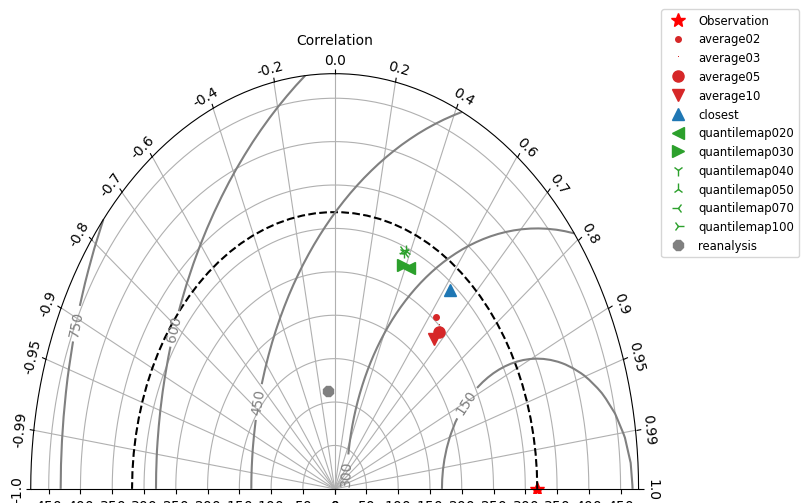

In [53]:
rascal.skill_evaluation.taylor_test(station_yearly_std, yearly_skill)

In [54]:
methods = sorted(list(set(reconstructions_yearly["similarity_method"].values)))
    

In [55]:
error_yearly = []
for method in methods:
    
    method_condition = (reconstructions_yearly["similarity_method"] == method)
    
    # Get individual reconstructions
    reconstruction = reconstructions_yearly.loc[method_condition]
    reconstruction = reconstruction.set_index("time")[variable_to_validate].to_frame()
    error = (reconstruction - station_data_yearly)
    
    error["similarity_method"] = method
    
    error = error.reset_index()
    error_yearly.append(error)

error_yearly = pd.concat(error_yearly, axis=0)
error_yearly = error_yearly.dropna()
error_yearly = error_yearly.reset_index()


error_reanalysis = reanalysis_data_yearly - station_data_yearly

In [56]:
reanalysis_data_yearly


,PCNR,observation
time,,
1899,167.462402,NaN
1900,579.028809,NaN
1901,423.278198,NaN
1902,422.386169,NaN
1903,444.333069,NaN
...,...,...
2006,503.237915,977.4
2007,582.719666,1185.6
2008,550.795593,1313.2


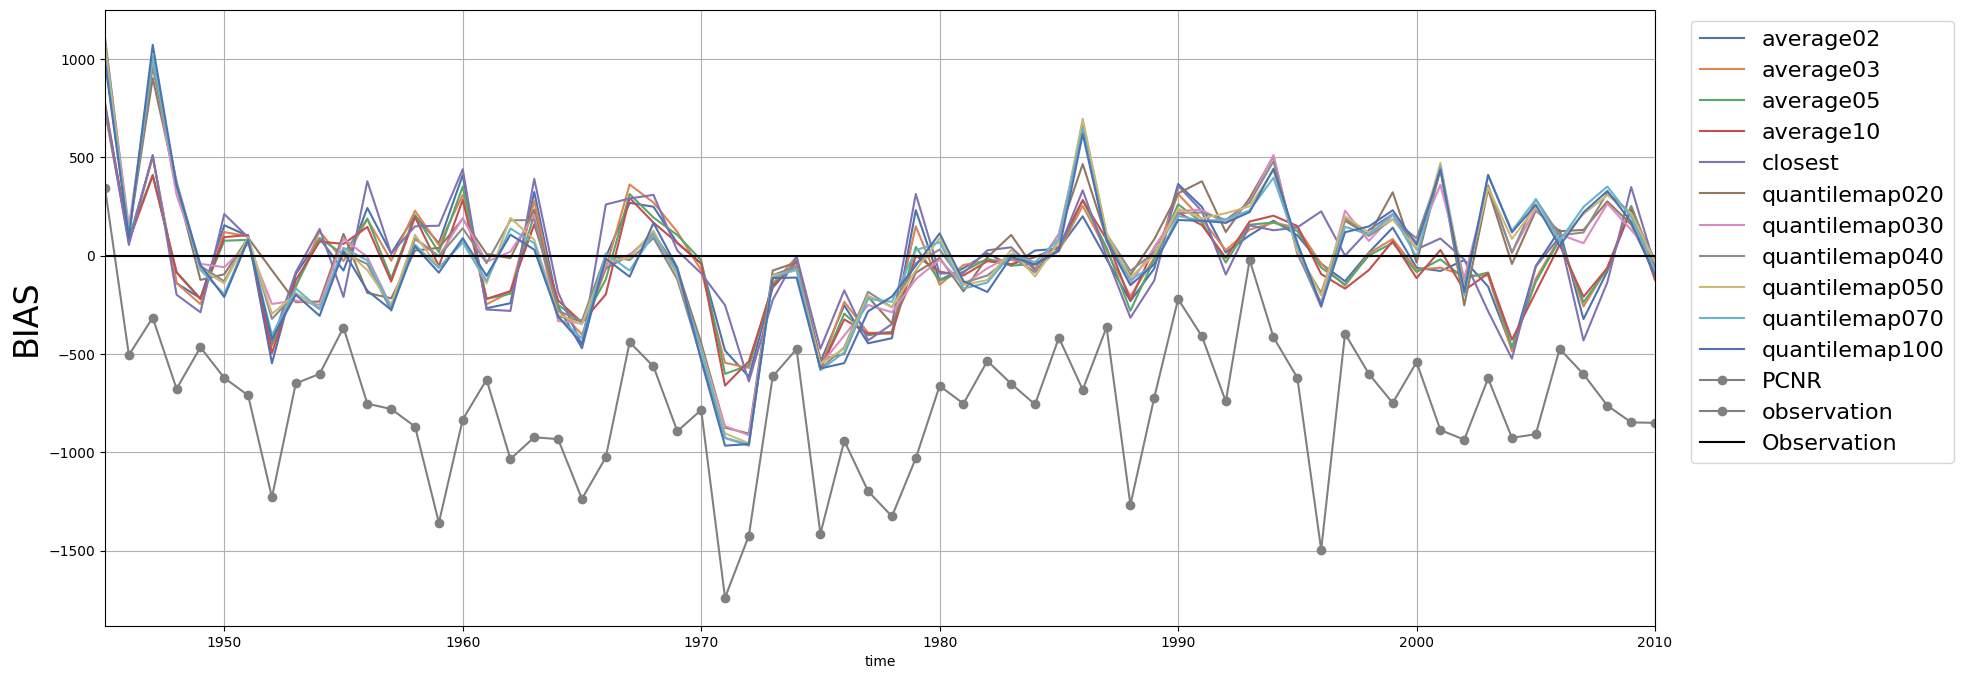

In [57]:
fig = plt.figure(figsize=(20,8))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=error_yearly, 
    x="time", 
    y=variable_to_validate, 
    hue="similarity_method", 
    palette="deep"
)
error_reanalysis.plot(color="grey", ax=ax, label="Reanalysis", marker='o')
ax.axhline(0, color="black", label="Observation")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.2, 1], fontsize=16)
ax.set_ylabel("BIAS", fontsize=24)
ax.set_xlim(error_yearly["time"].values[0], error_yearly["time"].values[-1])

ax.grid()

# 4) SEASONALITY

In [58]:
del daily_ensemble["reanalysis"]

### 4.1) Variable Annual Cycle

[Text(1, 0, 'J'),
 Text(2, 0, 'F'),
 Text(3, 0, 'M'),
 Text(4, 0, 'A'),
 Text(5, 0, 'M'),
 Text(6, 0, 'J'),
 Text(7, 0, 'J'),
 Text(8, 0, 'A'),
 Text(9, 0, 'S'),
 Text(10, 0, 'O'),
 Text(11, 0, 'N'),
 Text(12, 0, 'D')]

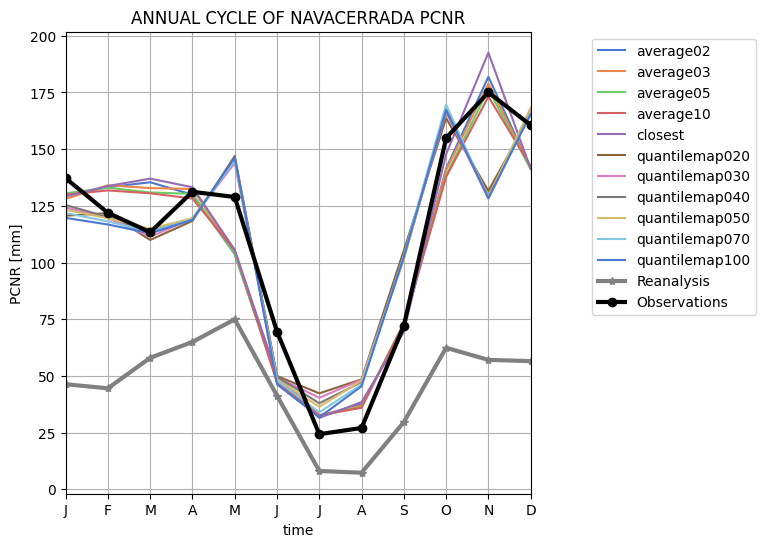

In [59]:
plt.rcParams.update({'font.size': 10})

fig = plt.figure(figsize=(6,6))
ax = fig.subplots()

seasonality = pd.DataFrame()

for model, reconstruction in daily_ensemble.items():
    
    reconstruction, observations = rascal.skill_evaluation.get_common_data(reconstruction, station_data_daily)
    reanalysis_data_i, observations = rascal.skill_evaluation.get_common_data(reanalysis_data_daily["PCNR"].to_frame(), station_data_daily)

    if variable_to_validate == "PCNR":
        reconstruction_monthly = reconstruction.resample('1m').sum()
        observation_monthly = observations.resample('1m').sum()
        reanalysis_monthly = reanalysis_data_i.resample('1m').sum()

        reconstruction_monthly = reconstruction_monthly.groupby(reconstruction_monthly.index.month).mean() 
        observation_monthly = observation_monthly.groupby(observation_monthly.index.month).mean() 
        reanalysis_monthly = reanalysis_monthly.groupby(reanalysis_monthly.index.month).mean() 
        
    else:
        reconstruction_monthly = reconstruction.groupby(reconstruction.index.month).mean() 
        observation_monthly = observations.groupby(observations.index.month).mean()
        reanalysis_monthly = reanalysis_data_i.groupby(reanalysis_data_i.index.month).mean() 
    
    reconstruction_monthly["method"] = model
    reconstruction_monthly.index.name = "month"

    seasonality = pd.concat([seasonality, reconstruction_monthly])

seasonality = seasonality.reset_index()  

sns.lineplot(ax=ax, data=seasonality, x="month", y=variable_to_validate, hue="method", palette="muted")
reanalysis_monthly.columns = ["Reanalysis"]
reanalysis_monthly.plot(ax=ax, color="grey", marker='*', linewidth=3)
observation_monthly.columns = ["Observations"]
observation_monthly.plot(ax=ax, label="Observations", color="black", marker='o', linewidth=3)
ax.legend(loc="upper right", bbox_to_anchor=[1.5, 1], ncol=1)
ax.set_xticks(range(1, 13))
ax.set_xlim(1,12)
ax.set_title("ANNUAL CYCLE OF " + station.name.upper() + " " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
ax.grid()
ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])


### 4.2) Variable Standard Deviation Annual Cycle

# 5) DISTRIBUTIONS

### 5.1) Daily Quantile-Quantile Diagram

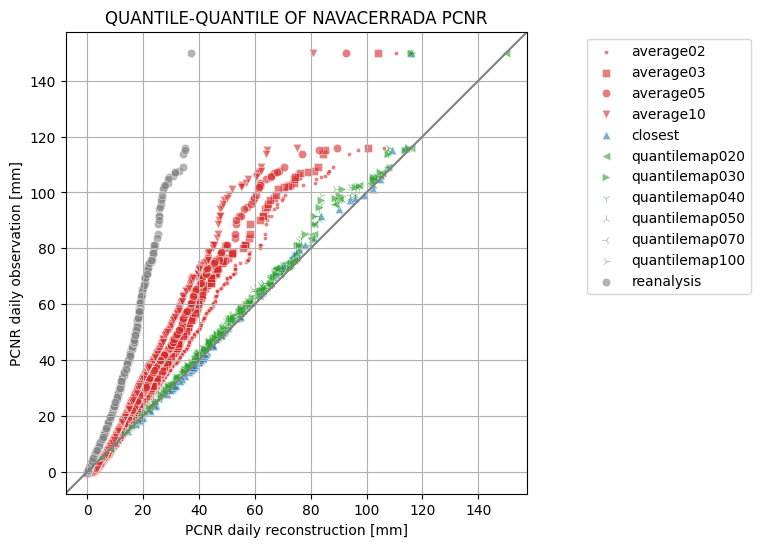

In [60]:
fig = plt.figure(figsize=(8, 6))
ax = fig.subplots()

for i, (model, reconstruction) in enumerate(daily_ensemble.items()):
    
    quantiles = rascal.skill_evaluation.quantile_plots(
        predicted=reconstruction, 
        observed=station_data_daily
    )

    if "closest" in model:
        color = "tab:blue"
    elif "average" in model:
        color = "tab:red"
    elif "quantilemap" in model:
        color = "tab:green"
    else:
        color = "grey"
        
    sns.scatterplot(
        data=quantiles, 
        x='Predicted', 
        y='Observed', 
        ax=ax, 
        alpha=0.6,
        color=color,
        label=model,
        marker=list(Line2D.markers.keys())[i]
    )
        
reanalysis_quantiles = rascal.skill_evaluation.quantile_plots(
        predicted=reanalysis_data_daily, 
        observed=station_data_daily
    )

sns.scatterplot(
        data=reanalysis_quantiles, 
        x='Predicted', 
        y='Observed', 
        ax=ax, 
        alpha=0.6,
        color="grey",
        label="reanalysis"
)
ax.axline([0, 0], [1, 1], color='grey')
ax.set_aspect('equal')
ax.grid()
ax.set_title("QUANTILE-QUANTILE OF " + station.name.upper() + " " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " daily observation " + units[variable_to_validate])
ax.set_xlabel(variable_to_validate + " daily reconstruction " + units[variable_to_validate])
ax.legend(loc="upper right", bbox_to_anchor=[1.5, 1], ncol=int(np.ceil(len(daily_ensemble)/20)))